<a href="https://www.kaggle.com/code/tornikeonoprishvili/fdtd-meep-oblique-source?scriptVersionId=98224331" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!conda install -y -c conda-forge pymeep pymeep-extras seaborn

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pymeep
    - pymeep-extras
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aom-3.3.0                  |       h27087fc_1         2.6 MB  conda-forge
    autograd-1.3               |             py_0          39 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  conda-forge
    cached_property-1.5.2      |     pyha770c72_1          11 KB  conda-forge
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-forge
    ffmpeg-5.0.1               |       h594f047_0        10.1 MB  conda-forge
    future-0.18.2              |   py37h89c1867_5         713 KB  conda-forge
    gmp-6.2.1                  |       h58526e2_0         806 KB  conda-forge
    gnutls-3.6.13              |       h85f3911_1         2.0 MB  conda-for

In [23]:
%load_ext autoreload
%autoreload 2

import meep as mp
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math 
import seaborn as sns
from itertools import product
from math import pi
from functools import partial
import os
import copy
import time

print(mpl.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.5.2


In [13]:
def run_sim(rot_angle = 0):

    resolution = 25 # pixels/μm

    cell_size = mp.Vector3(14,10,0)

    pml_layers = [mp.PML(thickness=2,direction=mp.X) ]

    fsrc = 1.0 # frequency of planewave (wavelength = 1/fsrc)

    n = 1.5 # refractive index of homogeneous material
    default_material = mp.Medium(index=n)

    k_point = mp.Vector3(fsrc*n).rotate(mp.Vector3(z=1), rot_angle)

    sources = [mp.EigenModeSource(src=mp.ContinuousSource(fsrc),
                                  center=mp.Vector3(),
                                  size=mp.Vector3(y=10),
                                  direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
                                  eig_kpoint=k_point,
                                  eig_band=1,
                                  eig_parity=mp.EVEN_Y+mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
                                  eig_match_freq=True)]
    geom = [
#         mp.Cylinder(
#             radius=1.5,#=mp.Vector3(2,2),
#             center=mp.Vector3(2.5,0),
#             material=mp.Medium(index=3)
#         )
    ]
    sim = mp.Simulation(cell_size=cell_size,
                        resolution=resolution,
                        boundary_layers=pml_layers,
                        sources=sources,
                        k_point=k_point,
                        geometry=geom,
                        default_material=default_material,
                        symmetries=[mp.Mirror(mp.Y)] if rot_angle == 0 else []
                       )
    
    f = plt.figure()
    anim = mp.Animate2D(sim, 
                        fields=mp.Ez,
                        f=f, realtime=False, 
                        normalize=True)
    plt.close()
    
    sim.run(mp.at_every(2,anim), until=70)
    os.makedirs('media/',exist_ok=True)
    filename = f"media/anim.mp4"
    anim.to_mp4(10,filename)

    plt.figure(dpi=100)
    sim.plot2D(fields=mp.Ez)
    plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000110865 s
Working in 2D dimensions.
Computational cell is 14 x 10 x 0 with resolution 25
time for set_epsilon = 0.130043 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(1.95811,0.964181,0) = 1 after 53 iters


FloatProgress(value=0.0, description='0% done ', max=70.0)

Meep progress: 63.480000000000004/70.0 = 90.7% done in 4.0s, 0.4s to go
on time step 3181 (time=63.62), 0.00125779 s/step
Normalizing field data...
run 0 finished at t = 70.0 (3500 timesteps)
Generating MP4...


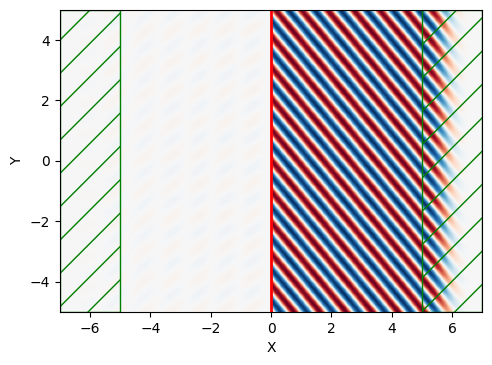

In [12]:
for rot_angle in np.radians([40]):
    run_sim(rot_angle)
from IPython.display import Video
Video("media/anim.mp4")

Note that this example involves a ContinuousSource for the time profile. For a pulsed source, the oblique planewave is incident at a given angle for only a single frequency component of the source. This is a fundamental feature of FDTD simulations and not of Meep per se. Thus, to simulate an incident planewave at multiple angles for a given frequency ω, you will need to do separate simulations involving different values of k⃗  (k_point) since each set of (k⃗ ,ω) specifying the Bloch-periodic boundaries and the frequency of the source will produce a different angle of the planewave. For more details, refer to Section 4.5 ("Efficient Frequency-Angle Coverage") in Chapter 4 ("Electromagnetic Wave Source Conditions") of Advances in FDTD Computational Electrodynamics: Photonics and Nanotechnology.

## Fields in a waveguide

In [139]:
def simulate(ratio = 0.21, 
             n_slabs = 24, 
             polarization = mp.Ez,
             vortex = False, 
             empty_sim = False,
             rot_angle = 0,
             animate = False,
             squeeze_x = True,
            ):
    rot_angle = np.radians(rot_angle)
    call_args = locals()
    # scale is nanometers
    # unit of distance is 1nm
    #ratio = 0.21 # Should block on both 12 and 24
    #polarization=mp.Ez
    vortex_rows = n_slabs * 2
    if squeeze_x:
        vortex_cols = 2#vortex_rows // 2 # At least 2:1 ratio is needed for non eigenmode
    else:
        vortex_cols = vortex_rows // 2
    # unit scale of simulation is h * 1.0

    h = 1 # nanometers
    lamd = h / ratio # nanometers
    k_0 = - 0.01 * ((h/lamd) ** (-2)) # Used for eps hat calculation
    min_eps = 1 + min( +k_0, -k_0 )
    
    if vortex:
        min_px_per_h = 12
    else: 
        min_px_per_h = 6
    
    resolution = math.ceil(max(1 / (lamd / 10), 1 / (h / min_px_per_h)))
    size_of_pixel = 1 / resolution

    pml_size = lamd * 0.50
    pml_depth = math.ceil(pml_size) # nm

    simulation_area = np.array([vortex_cols * h, (vortex_rows + 1) * h, 0])
    grid_size = simulation_area + [pml_depth * 0, pml_depth * 2, 0] # nm

    courant_factor = 0.9
    courant = courant_factor * (abs(min_eps) ** .5) / (2 ** .5)
    time_resolution = courant_factor * size_of_pixel
    
    # this is pixels per scale (nanometers here). 
    # The vortices have size 10nmx10nm, and consist of 
    # 6x6 cells. So, the resolution should be

    
    cell = mp.Vector3(*grid_size) / 1.
    W,H, _ = grid_size
    
    print(f'Resolution is {resolution} per h, k_0 is {k_0:.5f}, min_eps {min_eps}')    
    print(f'Grid size NU: {cell}, PX: {cell * resolution}')

#     geometry, sources, pml_layers = draw_geometry(
#         source_wavelength=lamd,
#         empty_space=empty_sim,
#         vortex= vortex)
    vortex_rads = np.zeros((6,6))
    d = 3
    for val in [pi * 1.5, pi, pi * .5, 0]:
        for x,y in product(range(6), range(6)):
            if y - d >= abs(x - d): 
                vortex_rads[x,y] = val
        vortex_rads = np.rot90(vortex_rads)
        
    W,H, _ = grid_size
    D = pml_depth

#     sources = [
#         mp.Source(
#             mp.ContinuousSource(wavelength=lamd,width=100),
#             component=polarization, #  NOTE: Direction matters!
#             size=mp.Vector3((W - D * 2) * .7 , 0, 0),
#             center=mp.Vector3(0, H/2 - D - h * .5, 0)
#         )
#     ]
    
    
    k_point = mp.Vector3(0,-1/lamd,0).rotate(mp.Vector3(z=1), rot_angle)
    sources = [mp.EigenModeSource(src=mp.ContinuousSource(wavelength=lamd),
                #component=polarization, # Needs both components
                size=mp.Vector3(W , 0, 0),
                center=mp.Vector3(0, H/2 - D - h * .5, 0),
              direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
              eig_kpoint=k_point,
              eig_band=1,
              eig_parity=mp.EVEN_Y+mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
              eig_match_freq=True)]
    
    pml_layers = [mp.PML(pml_size, direction=mp.Y)]
    
    geometry = []
    def make_eps_function_at(center, size):
        bins = np.linspace([-size.x/2,-size.y/2],[+size.x/2, +size.y/2],7)
        def eps_function(p):
            x,y = p.x - center.x, p.y - center.y
            x = np.digitize(x,bins[:,0],right=False)
            y = np.digitize(y,bins[:,1],right=False)
            x = np.clip(x, 1, 6) - 1
            y = np.clip(y, 1, 6) - 1
            eps_1 = 1 + k_0 * np.sin(vortex_rads[x,y]) ** 2 # first eps (for Ex)
            eps_3 = 1 + k_0 * np.cos(vortex_rads[x,y]) ** 2 # middle eps (for Ey)
            eps_4 = 1 # last eps (For Ez)
            return mp.Medium(epsilon_diag=(eps_1, eps_3, eps_4))
        return eps_function
    
    if not empty_sim:
        for row in range(vortex_rows):
            for col in range(vortex_cols):
                if row % 2 == 0: # Leave out air between rows
                    size = mp.Vector3(h,h,mp.inf)
                    center = mp.Vector3(
                        x=D + h / 2 + col * h - W / 2,
                        y=D + h * 1.5 + row * h - H / 2, 
                        z=0
                    )
                    if vortex:
                        material = make_eps_function_at(center, size)
                    else:
                        material = mp.Medium(epsilon=1 + k_0)
                    bl = mp.Block(
                        size=size,
                        center=center,
                        material=material
                    )
                    geometry.append(bl)
    
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        geometry_center=mp.Vector3(0,0,0),
        sources=sources,
        resolution=resolution,
        Courant=courant,
        k_point=k_point,
#         symmetries=[mp.Mirror(mp.X)] if rot_angle == 0 else []
    )
    
    sim.init_sim()
    eps_grid = sim.get_epsilon()
#     plt.figure(figsize=(15,7))
#     plt.imshow(z)
#     plt.colorbar()
#     os.makedirs('media', exist_ok=True)
#     plt.savefig("media/eps_map.png")
    
    vals = []
    
    def get_slice(sim):
        vals.append(
            sim.get_array(
                center=mp.Vector3(0,0,0), 
                size=mp.Vector3(0,H,0),
                component=polarization
            )
        )
        
    f = plt.figure()
    anim = mp.Animate2D(sim, 
                        fields=polarization,
                        f=f, 
                        realtime=False, 
                        normalize=True)
    plt.close()
    
    anim_name = ';'.join(list(str(k)+'-'+str(v) for k,v in call_args.items()))
    anim_name += ';'+time.strftime("%Y%m%d-%H%M%S")
    os.makedirs('media/',exist_ok=True)
    anim_filename = f"media/{anim_name}.mp4"
    
    
    callbacks = [
        mp.at_every(998, get_slice),
    ]

    if animate:
        callbacks.append(mp.at_every(20,anim))
        
    sim.run(
        *callbacks,
        until=1000,
    )
    if animate:
        anim.to_mp4(10,anim_filename)
        
#     plt.figure(figsize=(15,5))
#     plt.subplot(121)
#     plt.plot(vals[1])
#     plt.title(f'Ratio {ratio} with {vortex_rows // 2} row structure')
    
#     plt.subplot(122)
#     sim.plot2D()
#     plt.title('Grid')
#     plt.show()

#     sim.reset_meep()
#     tmp = locals()
#     loc_copy = {}
#     for name,val in tmp.items():
#         loc_copy[name] = copy.copy(val)
#     return loc_copy
    return locals()

In [144]:
mp.verbosity(0)
# res = simulate(0.26, empty_sim=False, animate=True, squeeze_x=True, rot_angle=0)
# res2 = simulate(0.26, empty_sim=False, animate=True, squeeze_x=True, rot_angle=0)

# res = simulate(0.30, empty_sim=False, animate=True, squeeze_x=False, rot_angle=45)
# res2 = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=45)


# res = simulate(0.30, empty_sim=False, animate=True, squeeze_x=False, rot_angle=30)
# res2 = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=30)

# res = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=45)
# from IPython.display import Video
# plt.plot(res['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])


Resolution is 6 per h, k_0 is -0.11111, min_eps 0.8888888888888888
Grid size NU: Vector3<24.0, 53.0, 0.0>, PX: Vector3<144.0, 318.0, 0.0>


/opt/conda/lib/python3.7/site-packages/meep/simulation.py:2041: RuntimeWarning: Epsilon < 1 may require adjusting the Courant parameter. See the 'Numerical Stability' entry under the 'Materials' section of the documentation
  warnings.warn(eps_warning, RuntimeWarning)


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Resolution is 6 per h, k_0 is -0.11111, min_eps 0.8888888888888888
Grid size NU: Vector3<24.0, 53.0, 0.0>, PX: Vector3<144.0, 318.0, 0.0>


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Resolution is 6 per h, k_0 is -0.11111, min_eps 0.8888888888888888
Grid size NU: Vector3<24.0, 53.0, 0.0>, PX: Vector3<144.0, 318.0, 0.0>


/opt/conda/lib/python3.7/site-packages/meep/simulation.py:2041: RuntimeWarning: Epsilon < 1 may require adjusting the Courant parameter. See the 'Numerical Stability' entry under the 'Materials' section of the documentation
  warnings.warn(eps_warning, RuntimeWarning)


FloatProgress(value=0.0, description='0% done ', max=1000.0)

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


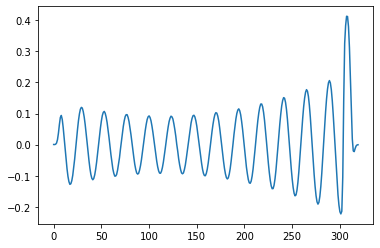

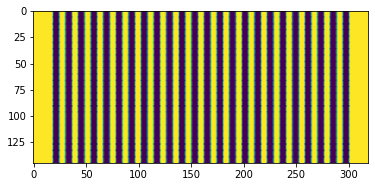

In [146]:
res = simulate(0.30, empty_sim=False, animate=True, squeeze_x=False, rot_angle=30)
from IPython.display import Video
plt.plot(res['vals'][0])
plt.figure()
plt.imshow(res['eps_grid'])
Video(res['anim_filename'])

Resolution is 6 per h, k_0 is -0.07716, min_eps 0.9228395061728395
Grid size NU: Vector3<24.0, 53.0, 0.0>, PX: Vector3<144.0, 318.0, 0.0>


/opt/conda/lib/python3.7/site-packages/meep/simulation.py:2041: RuntimeWarning: Epsilon < 1 may require adjusting the Courant parameter. See the 'Numerical Stability' entry under the 'Materials' section of the documentation
  warnings.warn(eps_warning, RuntimeWarning)


FloatProgress(value=0.0, description='0% done ', max=1000.0)

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


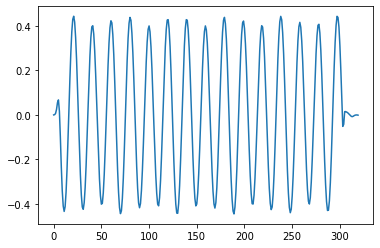

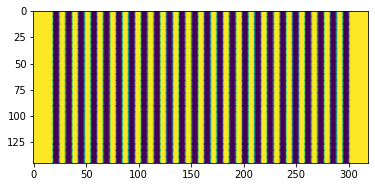

In [147]:
res = simulate(0.36, empty_sim=False, animate=True, squeeze_x=False, rot_angle=30)
from IPython.display import Video
plt.plot(res['vals'][0])
plt.figure()
plt.imshow(res['eps_grid'])
Video(res['anim_filename'])

Resolution is 6 per h, k_0 is -0.16000, min_eps 0.84
Grid size NU: Vector3<24.0, 53.0, 0.0>, PX: Vector3<144.0, 318.0, 0.0>


/opt/conda/lib/python3.7/site-packages/meep/simulation.py:2041: RuntimeWarning: Epsilon < 1 may require adjusting the Courant parameter. See the 'Numerical Stability' entry under the 'Materials' section of the documentation
  warnings.warn(eps_warning, RuntimeWarning)


FloatProgress(value=0.0, description='0% done ', max=1000.0)

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


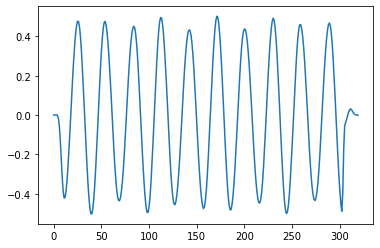

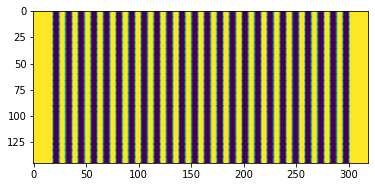

In [148]:
res = simulate(0.25, empty_sim=False, animate=True, squeeze_x=False, rot_angle=30)
from IPython.display import Video
plt.plot(res['vals'][0])
plt.figure()
plt.imshow(res['eps_grid'])
Video(res['anim_filename'])

Resolution is 6 per h, k_0 is -0.11111, min_eps 0.8888888888888888
Grid size NU: Vector3<24.0, 53.0, 0.0>, PX: Vector3<144.0, 318.0, 0.0>


FloatProgress(value=0.0, description='0% done ', max=1000.0)

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


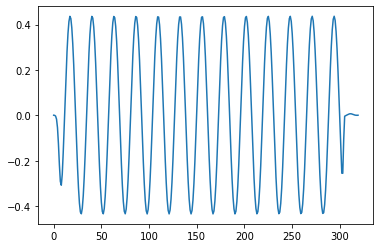

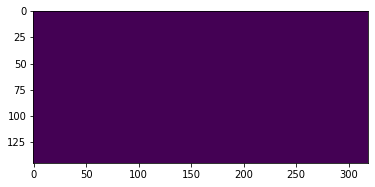

In [145]:
res2 = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=30)
from IPython.display import Video
plt.plot(res2['vals'][0])
plt.figure()
plt.imshow(res2['eps_grid'])
Video(res2['anim_filename'])

Resolution is 6 per h, k_0 is -0.11111, min_eps 0.8888888888888888
Grid size NU: Vector3<24.0, 53.0, 0.0>, PX: Vector3<144.0, 318.0, 0.0>


FloatProgress(value=0.0, description='0% done ', max=1000.0)

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


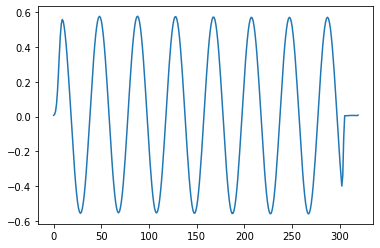

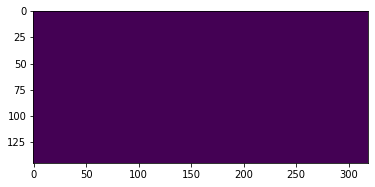

In [143]:
res = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=60)
from IPython.display import Video
plt.plot(res['vals'][0])
plt.figure()
plt.imshow(res['eps_grid'])
Video(res['anim_filename'])

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


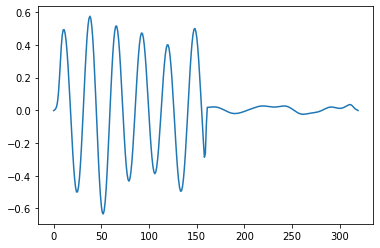

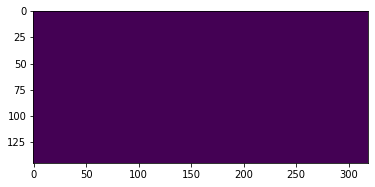

In [133]:
from IPython.display import Video
plt.plot(res['vals'][0])
plt.figure()
plt.imshow(res['eps_grid'])
Video(res['anim_filename'])

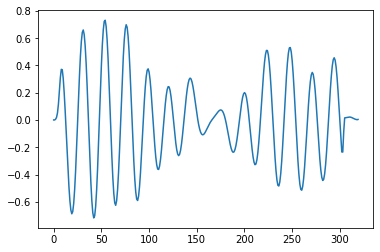

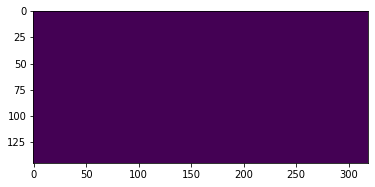

In [128]:
from IPython.display import Video
plt.plot(res2['vals'][0])
plt.figure()
plt.imshow(res2['eps_grid'])
Video(res2['anim_filename'])

In [10]:
results = {}
for r in tqdm(np.arange(0.21,0.34,0.01)):
    for rows in [32]:
        for empty_sim in [True, False]:
            results[(r,rows,empty_sim)] = simulate(
                    ratio = r, 
                    n_slabs = rows, 
                    polarization = mp.Ez,
                    vortex = False, 
                    empty_sim = empty_sim,
                    angle_d = 0,
                )

  0%|          | 0/14 [00:00<?, ?it/s]

Resolution is 6 per h, k_0 is -0.22676, min_eps 0.7732426303854875
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000375986 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
time for set_epsilon = 0.140298 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 618.8353059108996/1000.0 = 61.9% done in 4.0s, 2.5s to go
on time step 6640 (time=619.302), 0.000602413 s/step
run 0 finished at t = 1000.0229314207484 (10722 timesteps)
Resolution is 6 per h, k_0 is -0.22676, min_eps 0.7732426303854875
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00570917 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.773243,0.773243,0.773243)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.773243,0.773243,0.773243)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 609.4152055496335/1000.0 = 60.9% done in 4.0s, 2.6s to go
on time step 6548 (time=610.721), 0.000610908 s/step


  7%|▋         | 1/14 [00:13<03:00, 13.91s/it]

run 0 finished at t = 1000.0229314207484 (10722 timesteps)
Resolution is 6 per h, k_0 is -0.20661, min_eps 0.793388429752066
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000233173 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
time for set_epsilon = 0.137384 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 669.9257605347768/1000.0 = 67.0% done in 4.0s, 2.0s to go
on time step 7098 (time=670.587), 0.000563578 s/step
run 0 finished at t = 1000.0231526245399 (10585 timesteps)
Resolution is 6 per h, k_0 is -0.20661, min_eps 0.793388429752066
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00561094 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.793388,0.793388,0.793388)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.793388,0.793388,0.793388)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 609.4614414341905/1000.0 = 60.9% done in 4.0s, 2.6s to go
on time step 6465 (time=610.784), 0.000618771 s/step


 14%|█▍        | 2/14 [00:27<02:44, 13.68s/it]

run 0 finished at t = 1000.0231526245399 (10585 timesteps)
Resolution is 6 per h, k_0 is -0.18904, min_eps 0.8109640831758034
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226021 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
time for set_epsilon = 0.137263 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 690.1046007209345/1000.0 = 69.0% done in 4.0s, 1.8s to go
on time step 7235 (time=691.06), 0.000552934 s/step
run 0 finished at t = 1000.0546947471535 (10470 timesteps)
Resolution is 6 per h, k_0 is -0.18904, min_eps 0.8109640831758034
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00539494 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.810964,0.810964,0.810964)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.810964,0.810964,0.810964)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 641.391334787692/1000.0 = 64.1% done in 4.0s, 2.2s to go
on time step 6741 (time=643.875), 0.000593398 s/step


 21%|██▏       | 3/14 [00:40<02:26, 13.34s/it]

run 0 finished at t = 1000.0546947471535 (10470 timesteps)
Resolution is 6 per h, k_0 is -0.17361, min_eps 0.826388888888889
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000329971 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
time for set_epsilon = 0.142007 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 710.3283786720582/1000.0 = 71.0% done in 4.0s, 1.6s to go
on time step 7386 (time=712.16), 0.000541631 s/step
run 0 finished at t = 1000.0713918266035 (10372 timesteps)
Resolution is 6 per h, k_0 is -0.17361, min_eps 0.826388888888889
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.0050559 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.826389,0.826389,0.826389)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.826389,0.826389,0.826389)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.82

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 639.2666147136889/1000.0 = 63.9% done in 4.0s, 2.3s to go
on time step 6642 (time=640.424), 0.000602258 s/step


 29%|██▊       | 4/14 [00:53<02:11, 13.14s/it]

run 0 finished at t = 1000.0713918266035 (10372 timesteps)
Resolution is 6 per h, k_0 is -0.16000, min_eps 0.84
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000211954 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.127271 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 753.1916839689615/1000.0 = 75.3% done in 4.0s, 1.3s to go
on time step 7762 (time=754.553), 0.000515333 s/step
run 0 finished at t = 1000.0106934678248 (10287 timesteps)
Resolution is 6 per h, k_0 is -0.16000, min_eps 0.84
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00535297 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.84,0.84,0.84)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.84,0.84,0.84)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.84,0.84,0.84)
     block, center = (-

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 691.9486843690072/1000.0 = 69.2% done in 4.0s, 1.8s to go
on time step 7131 (time=693.212), 0.000560988 s/step


 36%|███▌      | 5/14 [01:05<01:54, 12.77s/it]

run 0 finished at t = 1000.0106934678248 (10287 timesteps)
Resolution is 6 per h, k_0 is -0.14793, min_eps 0.8520710059171598
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.13411 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 734.7927313114669/1000.0 = 73.5% done in 4.0s, 1.4s to go
on time step 7522 (time=736.457), 0.000531825 s/step
run 0 finished at t = 1000.0230456516088 (10214 timesteps)
Resolution is 6 per h, k_0 is -0.14793, min_eps 0.8520710059171598
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00554895 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.852071,0.852071,0.852071)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.852071,0.852071,0.852071)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 719.1275964667188/1000.0 = 71.9% done in 4.0s, 1.6s to go
on time step 7359 (time=720.498), 0.000543611 s/step


 43%|████▎     | 6/14 [01:17<01:39, 12.44s/it]

run 0 finished at t = 1000.0230456516088 (10214 timesteps)
Resolution is 6 per h, k_0 is -0.13717, min_eps 0.8628257887517147
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000212193 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.128543 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 762.469834548016/1000.0 = 76.2% done in 4.0s, 1.2s to go
on time step 7755 (time=764.046), 0.000515844 s/step
run 0 finished at t = 1000.0088927073734 (10150 timesteps)
Resolution is 6 per h, k_0 is -0.13717, min_eps 0.8628257887517147
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00515914 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.862826,0.862826,0.862826)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.862826,0.862826,0.862826)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 744.4401175661984/1000.0 = 74.4% done in 4.0s, 1.4s to go
on time step 7570 (time=745.819), 0.000528452 s/step


 50%|█████     | 7/14 [01:28<01:24, 12.12s/it]

run 0 finished at t = 1000.0088927073734 (10150 timesteps)
Resolution is 6 per h, k_0 is -0.12755, min_eps 0.8724489795918368
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.127935 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 754.6233449027361/1000.0 = 75.5% done in 4.0s, 1.3s to go
on time step 7632 (time=756.109), 0.000524152 s/step
run 0 finished at t = 1000.0220616316421 (10094 timesteps)
Resolution is 6 per h, k_0 is -0.12755, min_eps 0.8724489795918368
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00526214 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.872449,0.872449,0.872449)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.872449,0.872449,0.872449)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 689.2365249426723/1000.0 = 68.9% done in 4.0s, 1.8s to go
on time step 6965 (time=690.029), 0.000574408 s/step


 57%|█████▋    | 8/14 [01:40<01:12, 12.10s/it]

run 0 finished at t = 1000.0220616316421 (10094 timesteps)
Resolution is 6 per h, k_0 is -0.11891, min_eps 0.8810939357907254
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000314951 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.135358 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 740.5315076663593/1000.0 = 74.1% done in 4.0s, 1.4s to go
on time step 7460 (time=742.722), 0.000536219 s/step
run 0 finished at t = 1000.0859094526188 (10045 timesteps)
Resolution is 6 per h, k_0 is -0.11891, min_eps 0.8810939357907254
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00570011 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.881094,0.881094,0.881094)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.881094,0.881094,0.881094)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 736.449524362471/1000.0 = 73.6% done in 4.0s, 1.4s to go
on time step 7422 (time=738.939), 0.000538956 s/step


 64%|██████▍   | 9/14 [01:52<01:00, 12.04s/it]

run 0 finished at t = 1000.0859094526188 (10045 timesteps)
Resolution is 6 per h, k_0 is -0.11111, min_eps 0.888888888888889
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207901 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.128049 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

 64%|██████▍   | 9/14 [01:55<01:03, 12.78s/it]


KeyboardInterrupt: 

In [ ]:
for (r, rows, empty_sim),result in results.items():
    if not empty_sim:
        plt.figure(figsize=(6,2))
        plt.plot(result['vals'][0])
        plt.title(f'ratio {r}, rows {rows}, Empty? {empty_sim}')
        


In [ ]:
for (r, rows, empty_sim),result in results.items():
    if empty_sim:
        plt.figure(figsize=(6,2))
        plt.plot(result['vals'][0])
        plt.title(f'ratio {r}, rows {rows}, Empty? {empty_sim}')

In [ ]:
# def run_sim(sim, get_slice, anim=False, file_outputs=False):
#     callbacks = []
#     if anim:
#         f = plt.figure()
#         anim = mp.Animate2D(sim, fields=polarization, f=f, realtime=False, normalize=True)
#         plt.close()
#         callbacks.append(mp.at_every(40,anim))
#     if file_outputs:
#         os.makedirs('outputs',exist_ok=True)
#         !rm -rf eps*h5
#         !rm -rf hz.h5
#         callbacks.append( mp.at_beginning(mp.output_epsilon) )
        
#     vals = []
#     callbacks.append(mp.at_every(499,get_slice))
#     sim.run(
#         # mp.to_appended("hz",mp.at_every(4, mp.output_hfield_z)),
#         *callbacks,
#         until=1000,
#     )
#     return vals

In [ ]:
# !h5topng -t 0:125 \
# -R -Zc dkbluered \
# -a yarg \
# -A eps-000121.38.h5 hz.h5
# !h5ls hz.h5

In [ ]:
# os.makedirs('media/',exist_ok=True)
# filename = f"media/r{ratio:.3f}_h{vortex_rows}_phi{90}.mp4"
# anim.to_mp4(10,filename)
# from IPython.display import Video
# Video(filename)

In [ ]:
# from IPython.display import Video
# Video(filename)